# Determining the cost of cars

The used car sales service "Not beaten, not painted" is developing an application to attract new customers. You can quickly find out the market value of your car in it. Historical data is at your disposal: technical specifications, complete sets and prices of cars. You need to build a model to determine the cost. 

Important to the customer:

- quality of prediction;
- speed of prediction;
- training time.

## Importing libraries

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import Pool, cv
from catboost import CatBoostRegressor

## Data preparation

### Uploading and analyzing a dataframe

In [15]:
#загружаю датасет
data = pd.read_csv('autos.csv')

In [16]:
#вывожу первые пять столбцов
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [19]:
#общая информация о таблице
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [21]:
#числовая информация о таблице
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


### Removing abnormal values

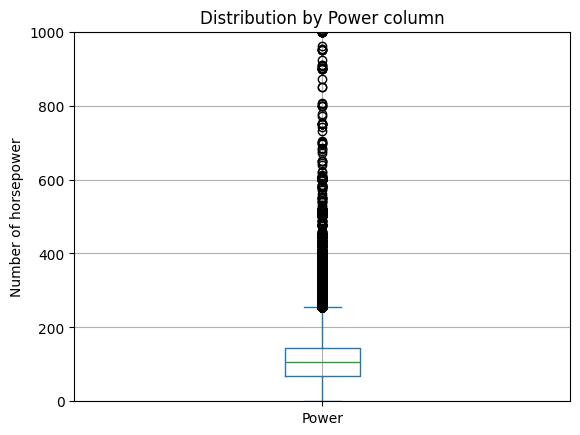

In [24]:
#строю ящик с усами для столбца power
data['Power'].plot.box()
plt.grid(True)
plt.ylim(0, 1000);
plt.ylabel('Number of horsepower');
plt.title('Distribution by Power column');

**I think it's worth removing values that are greater than 99.8 quantiles and equal to 0**

In [27]:
#убираю значения, которые больше 99,8 квантиля и равные нулю
data = data[(data['Power']<data['Power'].quantile(0.998))&(data['Power']>0)]

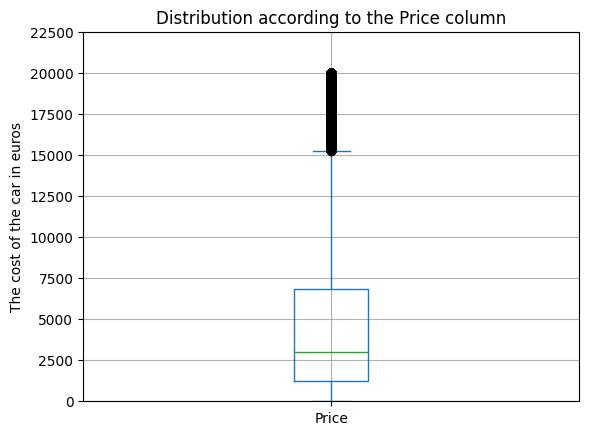

In [29]:
#строю ящик с усами для столбца price
data['Price'].plot.box()
plt.grid(True)
plt.ylim(0, 22500);
plt.ylabel('The cost of the car in euros');
plt.title('Distribution according to the Price column');

**In this case, I think it is necessary to remove values that are less than 5 quantiles.**

In [32]:
#убираю значения, которые меньше 1 квантиля
data = data[data['Price']>data['Price'].quantile(0.05)]

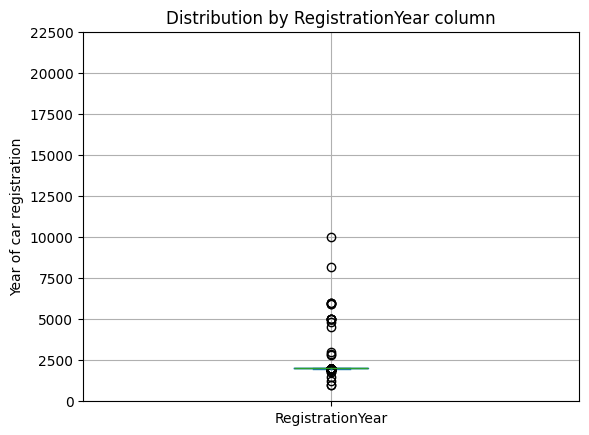

In [34]:
#строю ящик с усами для столбца RegistrationYear
data['RegistrationYear'].plot.box()
plt.grid(True)
plt.ylim(0, 22500);
plt.ylabel('Year of car registration');
plt.title('Distribution by RegistrationYear column');

**Since the project description does not say anything about the year of the data,
so we assume that the data should be deleted after 2023.**

In [37]:
#убираю значения больше 2023 года
data = data[data['RegistrationYear']<2023]

### Filling in the passes

In [40]:
#смотрю в каких столбцах пропуски и сколько их
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          19497
RegistrationYear         0
Gearbox               5490
Power                    0
Model                11563
Kilometer                0
RegistrationMonth        0
FuelType             17898
Brand                    0
Repaired             43420
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

**I believe that in the Model column, the missing values can be filled in with the word other. In the Repaired column, the gaps can be filled in with the word no. Let's assume that each seller is honest and did not indicate whether there was a repair or not, because there was no repair, and not because he wants to hide information from the buyer. And for the other columns, I have an idea how to fill in the passes.**

In [43]:
#заполняю пропуски в столбцах Model и Repaired
data['Model'] = data['Model'].fillna('other')
data['Repaired'] = data['Repaired'].fillna('no')

In [45]:
#создаю функцию для заполнения пропусков с помощью предсказания
def isna(data, column):
    #создаю список со всеми значениями столбца, в котором я буду заполнять пропуски
    a = data[column].unique()
    b = [np.nan]
    #убираю пропуски, чтобы не кодировать их
    z = [x for x in a if x not in b]
    #кодирую все значения цифрами, чтобы можно было обучить модель 
    for i in range(len(z)):
        data.loc[data[column]==z[i], column] = i
    #создаю две таблицы, в одной есть пропуски, а в другой нет
    x = data[data[column].isna()==0]
    y = data[data[column].isna()==1]
    #отделяю целевой признак от таблиц
    features_x = x.drop(labels=column, axis=1)
    target_x = x[column]
    #меняю тип данных, чтобы можно было обучить модель
    target_x = target_x.astype('int')
    features_y = y.drop(labels=column, axis=1)
    #заменяю категориальные признаки на цифры
    encoder = OrdinalEncoder()
    encoder.fit(features_x)
    x_ordinal = pd.DataFrame(encoder.transform(features_x), columns=features_x.columns)
    y_ordinal = pd.DataFrame(encoder.transform(features_y), columns=features_y.columns)
    #создаю и обучаю модель для предсказания пропусков
    model = DecisionTreeClassifier()
    model.fit(x_ordinal, target_x)
    predict = model.predict(y_ordinal)
    #создаю таблицу с двумя столбцами, в первом предсказания будут в числовом виде, а во втором предсказания будут в виде слов
    zero = []
    for k in range(len(predict)):
        zero.append(0)
    double_zero = list(zip(zero, zero))
    df = pd.DataFrame(double_zero, columns=['figure', 'words'])
    df['figure'] = predict
    for j in range(len(z)):
        df.loc[df['figure']==j, 'words'] = z[j]
    #считаю accuracy
    score = accuracy_score(target_x, model.predict(x_ordinal))
    return score, df

In [47]:
#предсказываю пропуски для столбца VehicleType
#разделяю таблицу на две части, в одной есть пропуски, а в другой нет
data0 = data[data['VehicleType'].isna()==0]
data1 = data[data['VehicleType'].isna()==1]
#создаю отдельную таблицу для функции
data2 = data[['Model', 'Brand', 'VehicleType']]
#сохраняю значение метрики и предсказания
score, df = isna(data2, 'VehicleType')
#вставляю предсказания
data1['VehicleType'] = np.array(df['words'])
#соединяю две таблицы
data = pd.concat([data0, data1])
#вывожу метрику, новую таблицу и проверяю есть ли пропуски
display(f'Насколько хорошо модель предсказала пропуски: {score}')
display(f'Количество пропусков:{data["VehicleType"].isna().sum()}')
data.head()

/var/folders/j1/s87kb4rs25s6jmdt61g1wsxr0000gn/T/ipykernel_51195/1706552367.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'coupe' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['figure']==j, 'words'] = z[j]
/var/folders/j1/s87kb4rs25s6jmdt61g1wsxr0000gn/T/ipykernel_51195/2394747498.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['VehicleType'] = np.array(df['words'])


'Насколько хорошо модель предсказала пропуски: 0.6643006639722864'

'Количество пропусков:0'

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07


In [49]:
#предсказываю пропуски для столбца Gearbox
#разделяю таблицу на две части, в одной есть пропуски, а в другой нет
data0 = data[data['Gearbox'].isna()==0]
data1 = data[data['Gearbox'].isna()==1]
#создаю отдельную таблицу для функции
data2 = data[['Model', 'Brand', 'Gearbox']]
#сохраняю значение метрики и предсказания
score, df = isna(data2, 'Gearbox')
#вставляю предсказания
data1['Gearbox'] = np.array(df['words'])
#соединяю две таблицы
data = pd.concat([data0, data1])
#вывожу метрику, новую таблицу и проверяю есть ли пропуски
display(f'Насколько хорошо модель предсказала пропуски: {score}')
display(f'Количество пропусков:{data["Gearbox"].isna().sum()}')
data.head()

/var/folders/j1/s87kb4rs25s6jmdt61g1wsxr0000gn/T/ipykernel_51195/1706552367.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'manual' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['figure']==j, 'words'] = z[j]
/var/folders/j1/s87kb4rs25s6jmdt61g1wsxr0000gn/T/ipykernel_51195/3610372632.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Gearbox'] = np.array(df['words'])


'Насколько хорошо модель предсказала пропуски: 0.8434978548880729'

'Количество пропусков:0'

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07


In [51]:
#предсказываю пропуски для столбца FuelType
#разделяю таблицу на две части, в одной есть пропуски, а в другой нет
data0 = data[data['FuelType'].isna()==0]
data1 = data[data['FuelType'].isna()==1]
#создаю отдельную таблицу для функции
data2 = data[['Model', 'Brand', 'FuelType']]
#сохраняю значение метрики и предсказания
score, df = isna(data2, 'FuelType')
#вставляю предсказания
data1['FuelType'] = np.array(df['words'])
#соединяю две таблицы
data = pd.concat([data0, data1])
#вывожу метрику, новую таблицу и проверяю есть ли пропуски
display(f'Насколько хорошо модель предсказала пропуски: {score}')
display(f'Количество пропусков:{data["FuelType"].isna().sum()}')
data.head()

/var/folders/j1/s87kb4rs25s6jmdt61g1wsxr0000gn/T/ipykernel_51195/1706552367.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'gasoline' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['figure']==j, 'words'] = z[j]
/var/folders/j1/s87kb4rs25s6jmdt61g1wsxr0000gn/T/ipykernel_51195/1560378766.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['FuelType'] = np.array(df['words'])


'Насколько хорошо модель предсказала пропуски: 0.7363581241321905'

'Количество пропусков:0'

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07


In [53]:
#еще раз проверяю, что в таблице не осталось ни одного пропуска
data.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

### Checking for duplicates

In [56]:
#считаю количество дубликатов
data.duplicated().sum()

5

In [58]:
#убираю дубликаты 
data = data.drop_duplicates(keep='first')

In [60]:
#проверяю
data.duplicated().sum()

0

### Removing uninformative signs

In [63]:
#создаю список ненужных признаков
unnecessary_features = ['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen']

In [65]:
#удаляю ненужные признаки 
data = data.drop(labels=unnecessary_features, axis=1)

In [67]:
#проверяю
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...,...,...
352626,1850,small,2000,manual,89,other,150000,7,petrol,fiat,no
352841,999,sedan,2017,auto,54,other,150000,0,petrol,mercedes_benz,no
353062,799,small,2018,manual,59,twingo,150000,11,petrol,renault,no
353104,1200,small,2000,manual,75,other,150000,0,petrol,volkswagen,no


### Conclusion: Saved the data, removed the anomalies from the Power and Price columns. In the Model and Repaired columns, I filled in the gaps with plugs, and in the FuelType, Gearbox, and VehicleType columns, I filled in the gaps with predictions, and in one of the columns, the metric wasn't super good, but I think it's much better than just filling in neutral values. Then I removed the duplicates, but there weren't many of them. In the end, I removed the uninformative signs.

## Preparing data for training

In [71]:
#разделяю данные на features и target
features = data.drop(labels='Price', axis=1)
target = data['Price']

In [73]:
#разделяю данные на две выборки 
features_train, features_temporary, target_train, target_temporary = train_test_split(features, target, test_size=0.45,
                                                                                      random_state=12345)
#разделяю временную выборку на две, на тестовую и валидационную
features_valid, features_test, target_valid, target_test = train_test_split(features_temporary, target_temporary,
                                                                            test_size=0.45, random_state=12345)
#проверяю
display(features_train.shape)
display(target_train.shape)
display(features_valid.shape)
display(target_valid.shape)
display(features_test.shape)
target_test.shape

(163136, 10)

(163136,)

(73411, 10)

(73411,)

(60065, 10)

(60065,)

In [75]:
#создаю список с категориальными данными
ordinal = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
#преобразовываю категориальные признаки с помощью техники OrdinalEncoder, поэтому в дальнейшем соревнование линейной регрессии не будет
encoder = OrdinalEncoder(handle_unknown='error')
encoder.fit(features_train.loc[:, ordinal])
features_train.loc[:, ordinal] = encoder.transform(features_train.loc[:, ordinal])
features_valid.loc[:, ordinal] = encoder.transform(features_valid.loc[:, ordinal])
features_test.loc[:, ordinal] = encoder.transform(features_test.loc[:, ordinal])

In [77]:
#поработаем с числами
scaler = StandardScaler()
scaler.fit(features_train)
features_train = pd.DataFrame(scaler.transform(features_train), columns=features_train.columns)
features_valid = pd.DataFrame(scaler.transform(features_valid), columns=features_valid.columns)
features_test = pd.DataFrame(scaler.transform(features_test), columns=features_test.columns)

### Conclusion: Prepared the data for training

## Model analysis

**will test wooden models at the very beginning**

In [82]:
#начну с дерева решений
grid_space = {'max_depth':[2, 3, 4, 5, 6, 7, 8, 9, 10],
             'max_features':[1, 3, 5, 7],
             'min_samples_leaf':[2, 3, 4], 
             'min_samples_split':[2, 3, 4],
             'random_state':[12345]}
#создаю модель
model = DecisionTreeRegressor()
grid = GridSearchCV(model, param_grid=grid_space, cv=3, scoring='neg_mean_squared_error')
model_grid = grid.fit(features_train, target_train)
#сохраняю наилучшии параметры
best_parametrs = model_grid.best_params_
best_parametrs

{'max_depth': 10,
 'max_features': 7,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'random_state': 12345}

In [83]:
%%time
model = DecisionTreeRegressor(**best_parametrs)
model.fit(features_train, target_train)

CPU times: user 117 ms, sys: 1.47 ms, total: 119 ms
Wall time: 118 ms


DecisionTreeRegressor(max_depth=10, max_features=7, min_samples_leaf=2,
                      random_state=12345)

In [86]:
%%time 
predict = model.predict(features_valid)
sqrt(mean_squared_error(target_valid, predict))

CPU times: user 10.5 ms, sys: 4.21 ms, total: 14.7 ms
Wall time: 10.7 ms


2035.8859865251104

In [88]:
#теперь случайный лес
grid_space = {'max_depth':[1, 2, 3, 4, 5],
             'n_estimators':[10, 20, 30, 40, 50],
             'random_state':[12345]}
#создаю модель
model = RandomForestRegressor()
grid = GridSearchCV(model, param_grid=grid_space, cv=3, scoring='neg_mean_squared_error')
model_grid = grid.fit(features_train, target_train)
#сохраняю наилучшии параметры
best_parametrs = model_grid.best_params_
best_parametrs

{'max_depth': 5, 'n_estimators': 40, 'random_state': 12345}

In [89]:
%%time
model = RandomForestRegressor(**best_parametrs)
model.fit(features_train, target_train)

CPU times: user 2.78 s, sys: 10.8 ms, total: 2.79 s
Wall time: 2.79 s


RandomForestRegressor(max_depth=5, n_estimators=40, random_state=12345)

In [90]:
%%time 
predict = model.predict(features_valid)
sqrt(mean_squared_error(target_valid, predict))

CPU times: user 60.7 ms, sys: 1.64 ms, total: 62.3 ms
Wall time: 61.6 ms


2442.3122753583243

In [91]:
#теперь проверю catboost
#ищу наилучшее количество итераций с помощью кроссвалидации
data_pool = Pool(data=features_train, label=target_train)
#создаю словарь параметров и подбираю learning_rate
params = {'eval_metric':'MAPE',
         'loss_function':'RMSE',
         'learning_rate':0.4,
         'random_seed':2007, 
         'verbose':1000}
cv_data = cv(
    params=params,
    pool=data_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    verbose=False,
    early_stopping_rounds=200
)

Training on fold [0/5]

bestTest = 0.3591298729
bestIteration = 997

Training on fold [1/5]

bestTest = 0.3594728078
bestIteration = 999

Training on fold [2/5]

bestTest = 0.3570560716
bestIteration = 989

Training on fold [3/5]

bestTest = 0.3611881022
bestIteration = 984

Training on fold [4/5]

bestTest = 0.3568578282
bestIteration = 995



In [92]:
params = {'iterations': 995,
         'eval_metric':'MAPE',
         'loss_function':'RMSE',
         'learning_rate':0.4,
         'random_seed':2007, 
         'verbose':100}
#создаю модель
model = CatBoostRegressor(**params)

In [93]:
%%time
model.fit(data_pool)

0:	learn: 1.4042646	total: 6.72ms	remaining: 6.68s
100:	learn: 0.3853652	total: 438ms	remaining: 3.88s
200:	learn: 0.3670565	total: 811ms	remaining: 3.21s
300:	learn: 0.3572985	total: 1.18s	remaining: 2.72s
400:	learn: 0.3491799	total: 1.54s	remaining: 2.29s
500:	learn: 0.3437409	total: 1.91s	remaining: 1.88s
600:	learn: 0.3395554	total: 2.28s	remaining: 1.49s
700:	learn: 0.3355989	total: 2.64s	remaining: 1.11s
800:	learn: 0.3319970	total: 3s	remaining: 727ms
900:	learn: 0.3289102	total: 3.36s	remaining: 351ms
994:	learn: 0.3265350	total: 3.71s	remaining: 0us
CPU times: user 16.6 s, sys: 5.36 s, total: 21.9 s
Wall time: 3.77 s


In [94]:
%%time
predict = model.predict(features_valid)
sqrt(mean_squared_error(target_valid, predict))

CPU times: user 94 ms, sys: 4.56 ms, total: 98.6 ms
Wall time: 12.6 ms


1574.0188581890939

## Checking the best model on a test sample

In [96]:
%%time
model = CatBoostRegressor(**params)
model.fit(features_train, target_train)

0:	learn: 1.4042646	total: 3.7ms	remaining: 3.68s
100:	learn: 0.3853652	total: 370ms	remaining: 3.27s
200:	learn: 0.3670565	total: 732ms	remaining: 2.89s
300:	learn: 0.3572985	total: 1.1s	remaining: 2.53s
400:	learn: 0.3491799	total: 1.47s	remaining: 2.18s
500:	learn: 0.3437409	total: 1.84s	remaining: 1.82s
600:	learn: 0.3395554	total: 2.21s	remaining: 1.45s
700:	learn: 0.3355989	total: 2.58s	remaining: 1.08s
800:	learn: 0.3319970	total: 2.94s	remaining: 711ms
900:	learn: 0.3289102	total: 3.3s	remaining: 344ms
994:	learn: 0.3265350	total: 3.65s	remaining: 0us
CPU times: user 16.4 s, sys: 5.35 s, total: 21.8 s
Wall time: 3.7 s


In [97]:
%%time
predict = model.predict(features_test)
sqrt(mean_squared_error(target_test, predict))

CPU times: user 82.6 ms, sys: 9.85 ms, total: 92.5 ms
Wall time: 13.3 ms


1608.8543000894083

**The general conclusion: At the very beginning, I uploaded the data and did the initial analysis. Then I removed the outliers, filled in the gaps, and removed duplicates and unnecessary features. After I started preparing the data for training, I transformed all the categorical data using the OrdinalEncoder technique, then brought all the numbers to the same scale using the StandardScaler. Next, I divided the data into two samples. After that, I started checking the models. In my opinion, the catboost model proved to be the best. So catboost is the most suitable for the customer.**